In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from beamline34IDC.simulation.facade.focusing_optics_interface import Movement

from beamline34IDC.util.shadow.common import \
    plot_shadow_beam_spatial_distribution, get_shadow_beam_spatial_distribution,\
    load_shadow_beam, PreProcessorFiles, EmptyBeamException
import beamline34IDC.optimization.common as opt_common
import beamline34IDC.optimization.movers as movers
from beamline34IDC.util import clean_up
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
import shutil
import glob

In [3]:
%matplotlib inline

In [4]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
print(DEFAULT_RANDOM_SEED)

513


In [5]:
base_dir = '/gpfs/fs1/home/skandel/code/oasys_ml/ML_Control_System/'
orig_work_dir = f'{base_dir}/work_directory'
temp_work_dir = f'{base_dir}/tmp_work_dir_{DEFAULT_RANDOM_SEED}'

In [6]:
os.mkdir(temp_work_dir)

In [7]:
dat_files = glob.glob(f'{orig_work_dir}/*.dat')
for df in dat_files:
    shutil.copy(df, temp_work_dir)

In [8]:
os.chdir(temp_work_dir)

In [9]:
input_beam_path = "primary_optics_system_beam.dat"

In [10]:
move_motors = ['hkb_q']

In [11]:
motors_str = move_motors[0] if len(move_motors) == 1 else '_'.join(move_motors)
fig_save_path = f'{orig_work_dir}/figures/{motors_str}/'
if not os.path.isdir(fig_save_path):
    os.mkdir(fig_save_path)

In [12]:
# Focusing Optics System -------------------------
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path)

9.594192371755397e-05


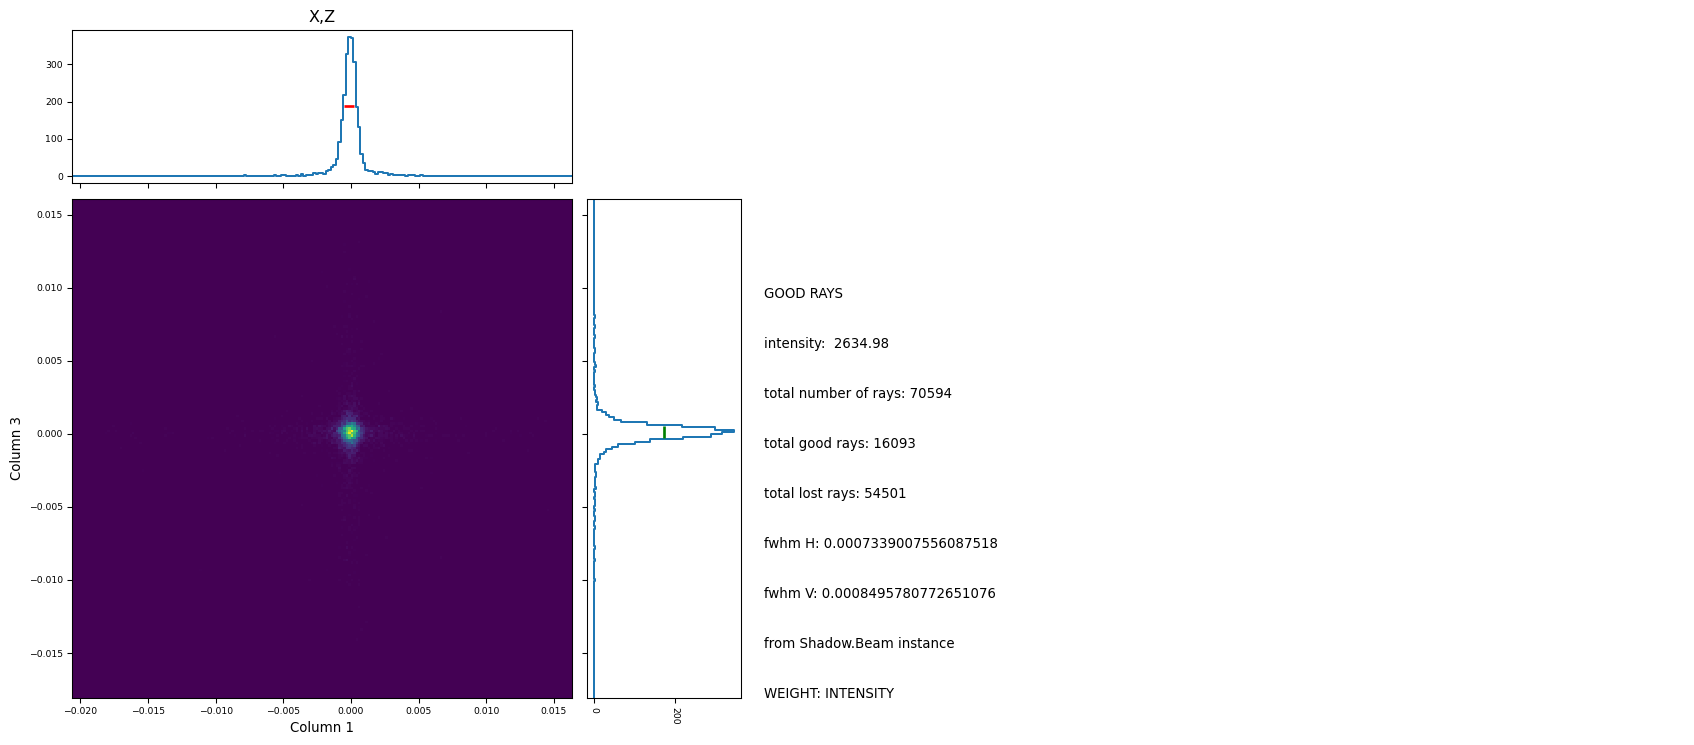

In [13]:
centroid, out_beam, hist, dw = opt_common.get_centroid_distance(focusing_system=focusing_system, 
                                                                random_seed=DEFAULT_RANDOM_SEED)
print(centroid)
_ = plot_shadow_beam_spatial_distribution(out_beam)

In [14]:
initial_absolute_positions = np.array(movers.get_absolute_positions(focusing_system, move_motors))
print(initial_absolute_positions)

[120.]


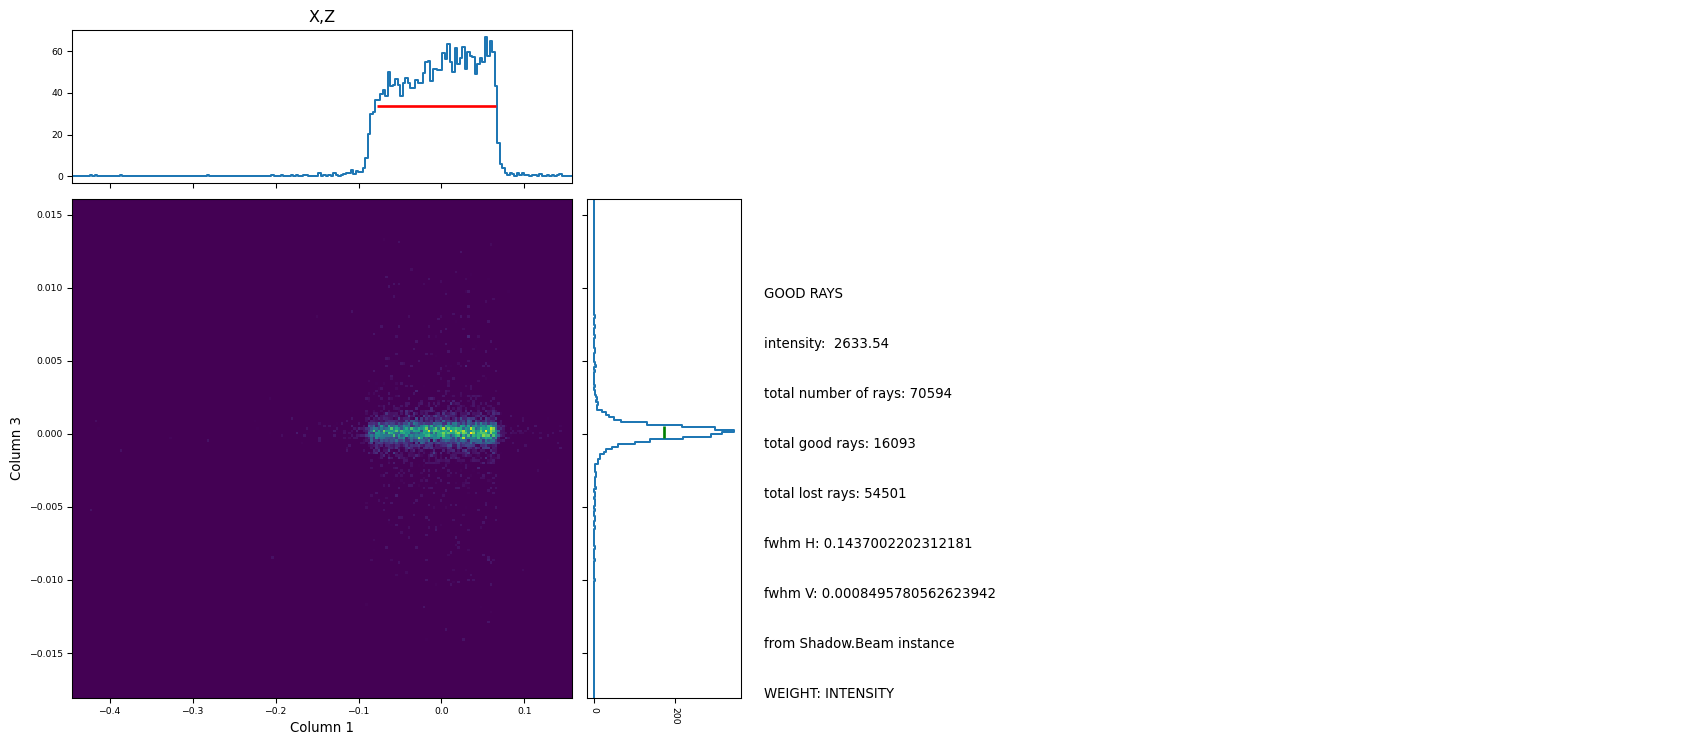

In [15]:
# check positive and negative movement
movers.move_motors(focusing_system, move_motors, -100, movement='relative')
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
plot_shadow_beam_spatial_distribution(beam)
movers.move_motors(focusing_system, move_motors, initial_absolute_positions, movement='absolute')

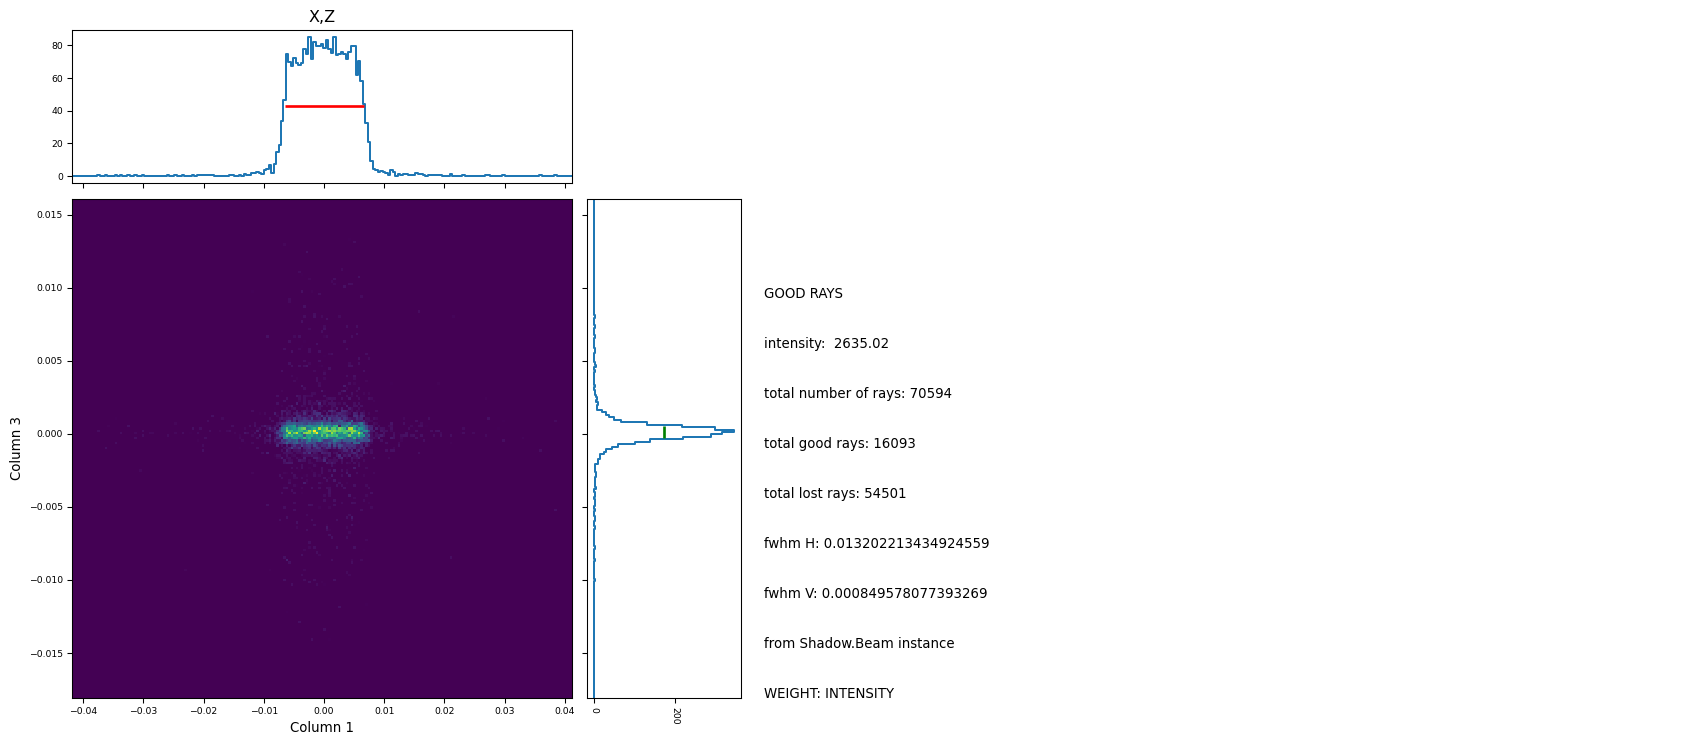

In [16]:
# check positive and negative movement
movers.move_motors(focusing_system, move_motors, 100, movement='relative')
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
plot_shadow_beam_spatial_distribution(beam)
movers.move_motors(focusing_system, move_motors, initial_absolute_positions, movement='absolute')

In [17]:
# Plotting the loss function for a grid of values

In [19]:
test_values = np.linspace(-100, 100, 100)
fwhm_values = []
for v in tqdm(test_values):
    focusing_system = movers.move_motors(focusing_system, move_motors, v, movement='relative')
    fwhm, out_beam, *_ = opt_common.get_fwhm(focusing_system=focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    focusing_system = movers.move_motors(focusing_system, move_motors, initial_absolute_positions, movement='absolute')
    fwhm_values.append(fwhm)

100%|██████████| 100/100 [02:37<00:00,  1.57s/it]


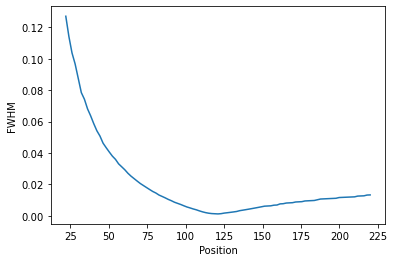

In [20]:
plt.plot(test_values + initial_absolute_positions[0], fwhm_values)
plt.xlabel('Position')
plt.ylabel('FWHM')
plt.show()

In [21]:
initial_losses = []
initial_out_beams = []
absolute_movements = []

start_guesses = []
overall_successes = []
final_losses = []
final_out_beams = []

min_trans = -100
max_trans = 100

for outer in tqdm(range(10)):
    translations = np.random.uniform(min_trans, max_trans, size=1)
    test_absolute_movements = initial_absolute_positions + translations
    print("Initial motor positions are", test_absolute_movements)
    absolute_movements.append(test_absolute_movements)
    
    focusing_system = movers.move_motors(focusing_system, move_motors, 
                                         test_absolute_movements,
                                         movement='absolute')
    fwhm, out_beam, hist, dw = opt_common.get_fwhm(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    
    initial_losses.append(fwhm)
    initial_out_beams.append(out_beam)
    
    opt_trial = opt_common.OptimizationCommon(focusing_system, 
                                              motor_types=move_motors, 
                                              initial_motor_positions=test_absolute_movements, 
                                              random_seed=DEFAULT_RANDOM_SEED,
                                              loss_parameter='fwhm')
    
    opt_results, guesses, solution, success = opt_trial.trials(verbose=True, guess_min=min_trans, guess_max=max_trans)
    focusing_system = opt_trial.focusing_system
    
    start_guesses.append(guesses)
    overall_successes.append(success)
    fwhm, out_beam, *_ = opt_common.get_fwhm(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    final_losses.append(fwhm)
    final_out_beams.append(out_beam)
    print(f'Test {outer} success {success}')

  0%|          | 0/10 [00:00<?, ?it/s]

Initial motor positions are [172.63922161]
motors ['hkb_q'] trans [0.] current loss 0.008781736262744404
Initial loss is 0.008781736262744404
motors ['hkb_q'] trans [15.05488302] current loss 0.010609085090026704
motors ['hkb_q'] trans [15.80762717] current loss 0.010282041371382392
motors ['hkb_q'] trans [16.56037132] current loss 0.010684182758811358
motors ['hkb_q'] trans [15.61944114] current loss 0.01063738663126806
motors ['hkb_q'] trans [15.80762717] current loss 0.010282041371382392
motors ['hkb_q'] trans [0.] current loss 0.008781736262744404
Initial loss is 0.008781736262744404
motors ['hkb_q'] trans [-71.57856164] current loss 0.00557643728195292
motors ['hkb_q'] trans [-75.15748972] current loss 0.006648942661780651
motors ['hkb_q'] trans [-67.99963355] current loss 0.004563739619248416
motors ['hkb_q'] trans [-60.84177739] current loss 0.002211804414170159
motors ['hkb_q'] trans [-50.10499314] current loss 0.0012849579855259924
motors ['hkb_q'] trans [-28.63142465] current

 10%|█         | 1/10 [00:34<05:06, 34.02s/it]

Test 0 success True
Initial motor positions are [40.93458753]
motors ['hkb_q'] trans [0.] current loss 0.05663034713479838
Initial loss is 0.05663034713479838
motors ['hkb_q'] trans [43.90964578] current loss 0.012114090513936918
motors ['hkb_q'] trans [46.10512807] current loss 0.011208659539903257
motors ['hkb_q'] trans [48.30061036] current loss 0.01011453650128507
motors ['hkb_q'] trans [52.69157494] current loss 0.00831545173207884
motors ['hkb_q'] trans [59.27802181] current loss 0.005869868615270078
motors ['hkb_q'] trans [72.45091554] current loss 0.0019735957093399027
motors ['hkb_q'] trans [92.21025614] current loss 0.0026790830864190152
motors ['hkb_q'] trans [77.39075069] current loss 0.0012312352234994455
motors ['hkb_q'] trans [82.33058584] current loss 0.001449040199813564
motors ['hkb_q'] trans [78.62570948] current loss 0.001245350011762789
motors ['hkb_q'] trans [76.1557919] current loss 0.001347247640294945
motors ['hkb_q'] trans [77.69949039] current loss 0.00123477

 20%|██        | 2/10 [01:44<07:24, 55.62s/it]

Test 1 success True
Initial motor positions are [184.8920379]
motors ['hkb_q'] trans [0.] current loss 0.009749207839011908
Initial loss is 0.009749207839011908
motors ['hkb_q'] trans [-52.0372486] current loss 0.0026690151801249556
motors ['hkb_q'] trans [-54.63911103] current loss 0.0023695974609190414
motors ['hkb_q'] trans [-57.24097346] current loss 0.0018970480698829535
motors ['hkb_q'] trans [-62.44469832] current loss 0.001283676784389006
motors ['hkb_q'] trans [-70.25028561] current loss 0.00157759463296905
motors ['hkb_q'] trans [-64.39609514] current loss 0.0011266618329449454
motors ['hkb_q'] trans [-66.34749197] current loss 0.0012337523558893068
motors ['hkb_q'] trans [-64.88394435] current loss 0.0011227376494696037
motors ['hkb_q'] trans [-65.37179355] current loss 0.0012448949835173453
motors ['hkb_q'] trans [-64.76198205] current loss 0.0011237208775280957
motors ['hkb_q'] trans [-65.00590665] current loss 0.0012490550497798187
motors ['hkb_q'] trans [-64.85345377] cu

 30%|███       | 3/10 [02:42<06:36, 56.64s/it]

Test 2 success True
Initial motor positions are [76.49895013]
motors ['hkb_q'] trans [0.] current loss 0.016564190923985655
Initial loss is 0.016564190923985655
motors ['hkb_q'] trans [58.94949811] current loss 0.003214500935632905
motors ['hkb_q'] trans [61.89697302] current loss 0.0035762890199463344
motors ['hkb_q'] trans [56.00202321] current loss 0.002656776097361689
motors ['hkb_q'] trans [50.10707339] current loss 0.0016870894963137923
motors ['hkb_q'] trans [41.26464868] current loss 0.0012247543375337676
motors ['hkb_q'] trans [23.57979924] current loss 0.005856063759227888
motors ['hkb_q'] trans [32.42222396] current loss 0.0030780823497210544
motors ['hkb_q'] trans [43.47525486] current loss 0.001122463143667698
motors ['hkb_q'] trans [45.68586104] current loss 0.0012798156250068559
motors ['hkb_q'] trans [42.92260331] current loss 0.0012437710397794925
motors ['hkb_q'] trans [43.47525486] current loss 0.001122463143667698


 40%|████      | 4/10 [03:07<04:23, 43.99s/it]

Test 3 success True
Initial motor positions are [96.76869326]
motors ['hkb_q'] trans [0.] current loss 0.007141419987330542
Initial loss is 0.007141419987330542
motors ['hkb_q'] trans [-9.85752476] current loss 0.011194449886445638
motors ['hkb_q'] trans [-10.35040099] current loss 0.011478879639297767
motors ['hkb_q'] trans [-9.36464852] current loss 0.01094868815888282
motors ['hkb_q'] trans [-8.37889604] current loss 0.010444061616195825
motors ['hkb_q'] trans [-6.90026733] current loss 0.009863186965841465
motors ['hkb_q'] trans [-3.9430099] current loss 0.0085898441769617
motors ['hkb_q'] trans [0.49287624] current loss 0.006975352884943664
motors ['hkb_q'] trans [9.36464852] current loss 0.0038467380256256957
motors ['hkb_q'] trans [22.67230694] current loss 0.0012439922588829264
motors ['hkb_q'] trans [49.28762378] current loss 0.004959036348755818
motors ['hkb_q'] trans [35.97996536] current loss 0.002665350542709258
motors ['hkb_q'] trans [25.99922154] current loss 0.001288362

 50%|█████     | 5/10 [03:50<03:39, 43.90s/it]

Test 4 success True
Initial motor positions are [169.54974334]
motors ['hkb_q'] trans [0.] current loss 0.008286240108979308
Initial loss is 0.008286240108979308
motors ['hkb_q'] trans [78.08382496] current loss 0.014663917390331686
motors ['hkb_q'] trans [81.9880162] current loss 0.014790394060248298
motors ['hkb_q'] trans [74.17963371] current loss 0.014533175074994065
motors ['hkb_q'] trans [66.37125121] current loss 0.0138288566483181
motors ['hkb_q'] trans [54.65867747] current loss 0.013396173255373033
motors ['hkb_q'] trans [31.23352998] current loss 0.01122458101685391
motors ['hkb_q'] trans [-3.90419125] current loss 0.00807416602956195
motors ['hkb_q'] trans [-74.17963371] current loss 0.007619659802978764
motors ['hkb_q'] trans [-179.5927974] current loss inf
motors ['hkb_q'] trans [-47.82634279] current loss 0.0011388545768633808
motors ['hkb_q'] trans [-21.47305186] current loss 0.005608176809004636
motors ['hkb_q'] trans [-41.23802006] current loss 0.0019140349751605823
m

 60%|██████    | 6/10 [04:33<02:53, 43.29s/it]

Test 5 success True
Initial motor positions are [146.26027381]
motors ['hkb_q'] trans [0.] current loss 0.004969422184267713
Initial loss is 0.004969422184267713
motors ['hkb_q'] trans [-36.92410253] current loss 0.00310407604467221
motors ['hkb_q'] trans [-38.77030765] current loss 0.003539902360386342
motors ['hkb_q'] trans [-35.0778974] current loss 0.002332565398909688
motors ['hkb_q'] trans [-31.38548715] current loss 0.0015828943100318332
motors ['hkb_q'] trans [-25.84687177] current loss 0.0011259983806765253
motors ['hkb_q'] trans [-14.76964101] current loss 0.00240921336489157
motors ['hkb_q'] trans [-20.30825639] current loss 0.0016725472763754422
motors ['hkb_q'] trans [-27.23152561] current loss 0.001239301926149814
motors ['hkb_q'] trans [-24.46221792] current loss 0.0012741102019338574
motors ['hkb_q'] trans [-26.19303523] current loss 0.0011232143696950974
motors ['hkb_q'] trans [-26.53919869] current loss 0.0012471795320958532
motors ['hkb_q'] trans [-26.10649436] curre

 70%|███████   | 7/10 [05:27<02:21, 47.02s/it]

Test 6 success True
Initial motor positions are [201.01633394]
motors ['hkb_q'] trans [0.] current loss 0.011620029828920422
Initial loss is 0.011620029828920422
motors ['hkb_q'] trans [67.93417661] current loss 0.01623435185479353
motors ['hkb_q'] trans [71.33088544] current loss 0.01633340388314274
motors ['hkb_q'] trans [64.53746778] current loss 0.01613267708770639
motors ['hkb_q'] trans [57.74405012] current loss 0.015467651922096277
motors ['hkb_q'] trans [47.55392363] current loss 0.014694574836507476
motors ['hkb_q'] trans [27.17367065] current loss 0.013548334523455278
motors ['hkb_q'] trans [-3.39670883] current loss 0.011083217683094533
motors ['hkb_q'] trans [-64.53746778] current loss 0.0032574214717213884
motors ['hkb_q'] trans [-156.24860621] current loss 0.049515910680221924
motors ['hkb_q'] trans [-41.60968318] current loss 0.006799901600432497
motors ['hkb_q'] trans [-87.46525239] current loss 0.0018332018790075044
motors ['hkb_q'] trans [-133.3208216] current loss 0.

 80%|████████  | 8/10 [06:36<01:47, 53.98s/it]

Test 7 success True
Initial motor positions are [103.16454623]
motors ['hkb_q'] trans [0.] current loss 0.0049853935906363665
Initial loss is 0.0049853935906363665
motors ['hkb_q'] trans [88.62381609] current loss 0.010810555749873363
motors ['hkb_q'] trans [93.0550069] current loss 0.011019229784286176
motors ['hkb_q'] trans [84.19262529] current loss 0.010592111489451666
motors ['hkb_q'] trans [75.33024368] current loss 0.009429715050401315
motors ['hkb_q'] trans [62.03667126] current loss 0.008049412086535404
motors ['hkb_q'] trans [35.44952644] current loss 0.0038279570274341434
motors ['hkb_q'] trans [-4.4311908] current loss 0.006323066362429883
motors ['hkb_q'] trans [25.47934713] current loss 0.0019224885168521648
motors ['hkb_q'] trans [15.50916782] current loss 0.0012352302763400545
motors ['hkb_q'] trans [-4.4311908] current loss 0.006323066362431112
motors ['hkb_q'] trans [5.53898851] current loss 0.0030643594426462708
motors ['hkb_q'] trans [18.00171264] current loss 0.001

 90%|█████████ | 9/10 [07:33<00:54, 54.72s/it]

Test 8 success True
Initial motor positions are [165.27500583]
motors ['hkb_q'] trans [0.] current loss 0.008053519244685892
Initial loss is 0.008053519244685892
motors ['hkb_q'] trans [-40.86261464] current loss 0.0014704920807160802
motors ['hkb_q'] trans [-42.90574537] current loss 0.0012825297216510908
motors ['hkb_q'] trans [-44.94887611] current loss 0.0011252943502813575
motors ['hkb_q'] trans [-49.03513757] current loss 0.0014706539681706608
motors ['hkb_q'] trans [-46.99200684] current loss 0.0012307452757744093
motors ['hkb_q'] trans [-45.45965879] current loss 0.0012482528015877882
motors ['hkb_q'] trans [-44.94887611] current loss 0.0011252943502813575


100%|██████████| 10/10 [07:51<00:00, 47.11s/it]

Test 9 success True


In [22]:
initial_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in initial_out_beams]
initial_hists, initial_dws = zip(*initial_hists_dws)

In [23]:
initial_peaks = [dw.get_parameter('peak_intensity') for dw in initial_dws]
initial_h_fwhms = [dw.get_parameter('h_fwhm') for dw in initial_dws]
initial_v_fwhms = [dw.get_parameter('v_fwhm') for dw in initial_dws]

In [24]:
final_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in final_out_beams]
final_hists, final_dws = zip(*final_hists_dws)

In [25]:
final_peaks = [dw.get_parameter('peak_intensity') for dw in final_dws]
final_h_fwhms = [dw.get_parameter('h_fwhm') for dw in final_dws]
final_v_fwhms = [dw.get_parameter('v_fwhm') for dw in final_dws]

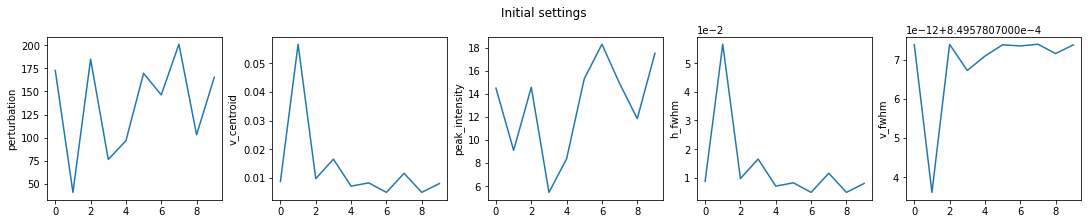

In [27]:
fig, axes = plt.subplots(1, 5, figsize=[15,3], constrained_layout=True)

axes[0].plot(absolute_movements)
axes[0].set_ylabel('perturbation')

axes[1].plot(initial_losses)
axes[1].set_ylabel('v_centroid')

axes[2].plot(initial_peaks)
axes[2].set_ylabel('peak_intensity')

axes[3].plot(initial_h_fwhms)
axes[3].set_ylabel('h_fwhm')
axes[3].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[4].plot(initial_v_fwhms)
axes[4].set_ylabel('v_fwhm')
axes[4].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('Initial settings')
fig.savefig(f'{fig_save_path}/initial_metrics.png', bbox_inches='tight')

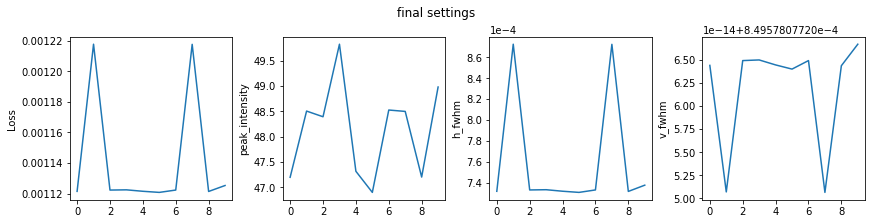

In [29]:
fig, axes = plt.subplots(1, 4, figsize=[12,3], constrained_layout=True)

axes[0].plot(final_losses)
axes[0].set_ylabel('Loss')

axes[1].plot(final_peaks)
axes[1].set_ylabel('peak_intensity')

axes[2].plot(final_h_fwhms)
axes[2].set_ylabel('h_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[3].plot(final_v_fwhms)
axes[3].set_ylabel('v_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('final settings')
fig.savefig(f'{fig_save_path}/final_metrics.png', bbox_inches='tight')

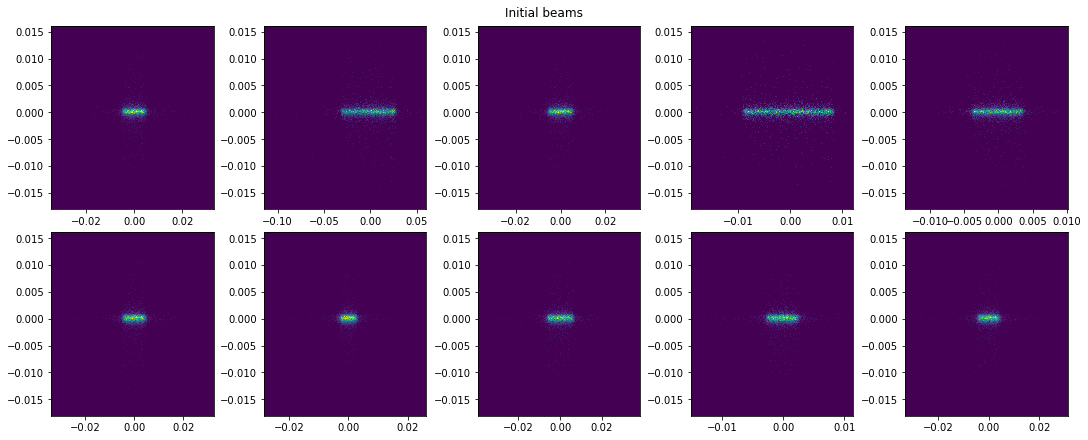

In [30]:
fig, axes = plt.subplots(2, 5, figsize=[15,6], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(initial_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D)
    
    
fig.suptitle('Initial beams')
fig.savefig(f'{fig_save_path}/initial_beams.png', bbox_inches='tight')

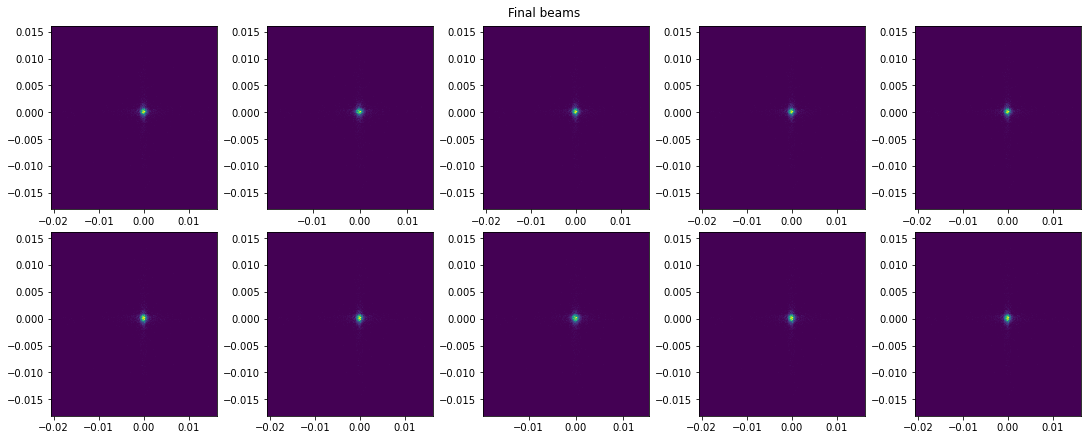

In [31]:
fig, axes = plt.subplots(2, 5, figsize=[15,6], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(final_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D)
    
    
fig.suptitle('Final beams')
fig.savefig(f'{fig_save_path}/final_beams.png', bbox_inches='tight')

In [39]:
# Test gaussian process optimization

In [36]:
import skopt

In [49]:
callback = skopt.callbacks.DeltaYStopper(1e-3)

In [50]:
%%time
initial_losses = []
initial_out_beams = []
absolute_movements = []

start_guesses = []
overall_successes = []
final_losses = []
final_out_beams = []
opt_results_all = []

min_trans = -100.
max_trans = 100.

for outer in tqdm(range(10)):
    translations = np.random.uniform(min_trans, max_trans, size=1)
    test_absolute_movements = initial_absolute_positions + translations
    print("Initial motor positions are", test_absolute_movements)
    absolute_movements.append(test_absolute_movements)
    
    focusing_system = movers.move_motors(focusing_system, move_motors, 
                                         test_absolute_movements,
                                         movement='absolute')
    fwhm, out_beam, hist, dw = opt_common.get_fwhm(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    
    initial_losses.append(fwhm)
    initial_out_beams.append(out_beam)
    
    opt_trial = opt_common.OptimizationCommon(focusing_system, 
                                              motor_types=move_motors, 
                                              initial_motor_positions=test_absolute_movements, 
                                              random_seed=DEFAULT_RANDOM_SEED,
                                              loss_parameter='fwhm')
    opt_trial.set_gaussian_process_optimizer(bounds=[min_trans, max_trans], callback=callback)
    
    opt_results, guesses, solution, success = opt_trial.trials(verbose=True, guess_min=min_trans, guess_max=max_trans)
    focusing_system = opt_trial.focusing_system
    
    start_guesses.append(guesses)
    overall_successes.append(success)
    fwhm, out_beam, *_ = opt_common.get_fwhm(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    final_losses.append(fwhm)
    final_out_beams.append(out_beam)
    opt_results_all.append(opt_results)
    print(f'Test {outer} success {success}')

  0%|          | 0/10 [00:00<?, ?it/s]

Initial motor positions are [116.14518776]
motors ['hkb_q'] trans [0.] current loss 0.001468875822236916
Initial loss is 0.001468875822236916
motors ['hkb_q'] trans [-12.56319429] current loss 0.004754513010497626
motors ['hkb_q'] trans [36.04751347] current loss 0.006115636363651106
motors ['hkb_q'] trans [-60.81515755] current loss 0.0342250056306328
motors ['hkb_q'] trans [-83.92405261] current loss 0.07932494409776719
motors ['hkb_q'] trans [78.2798723] current loss 0.010935872636958681
motors ['hkb_q'] trans [-88.54144434] current loss 0.09773161046325517
motors ['hkb_q'] trans [31.95072384] current loss 0.005609245348507629
motors ['hkb_q'] trans [-84.39679075] current loss 0.08274055601909946
motors ['hkb_q'] trans [72.50302055] current loss 0.010291735818420054
motors ['hkb_q'] trans [74.87702598] current loss 0.010773482636865088
motors ['hkb_q'] trans [6.60258581] current loss 0.0012880688246544347
motors ['hkb_q'] trans [100.] current loss 0.01307117269844435
motors ['hkb_q'

 10%|█         | 1/10 [00:42<06:19, 42.18s/it]

Test 0 success True
Initial motor positions are [201.08555459]
motors ['hkb_q'] trans [0.] current loss 0.011623166815398222
Initial loss is 0.011623166815398222
motors ['hkb_q'] trans [62.11729226] current loss 0.016060812319859147
motors ['hkb_q'] trans [-95.9155166] current loss 0.004196176528143917
motors ['hkb_q'] trans [-95.32499676] current loss 0.004096395260973825
motors ['hkb_q'] trans [66.15107672] current loss 0.016183374348024714
motors ['hkb_q'] trans [-40.26632128] current loss 0.007181457883271339
motors ['hkb_q'] trans [-25.47815933] current loss 0.008937172742687986
motors ['hkb_q'] trans [-32.59159145] current loss 0.008229923350714017
motors ['hkb_q'] trans [2.95032734] current loss 0.011754912827554994
motors ['hkb_q'] trans [65.16755341] current loss 0.016153826018288152
motors ['hkb_q'] trans [77.4277759] current loss 0.01650716413981849
motors ['hkb_q'] trans [-81.63973714] current loss 0.0012440451539045283
motors ['hkb_q'] trans [99.98679403] current loss 0.01

 20%|██        | 2/10 [01:24<05:36, 42.06s/it]

Test 1 success True
Initial motor positions are [95.72627688]
motors ['hkb_q'] trans [0.] current loss 0.007448179138567517
Initial loss is 0.007448179138567517
motors ['hkb_q'] trans [94.1748147] current loss 0.01071873588994279
motors ['hkb_q'] trans [-6.27821839] current loss 0.010028540789237275
motors ['hkb_q'] trans [89.25178097] current loss 0.009753359587451042
motors ['hkb_q'] trans [-48.40796489] current loss 0.04529377994376574
motors ['hkb_q'] trans [-68.15395008] current loss 0.09616844359135451
motors ['hkb_q'] trans [94.09684831] current loss 0.01071493094022787
motors ['hkb_q'] trans [-74.54128084] current loss 0.1356270096932074
motors ['hkb_q'] trans [44.04097775] current loss 0.004128274498776496
motors ['hkb_q'] trans [36.28043548] current loss 0.002639493427064989
motors ['hkb_q'] trans [4.86668406] current loss 0.0057832422826736
motors ['hkb_q'] trans [65.73130559] current loss 0.007525414064055148
motors ['hkb_q'] trans [21.15750039] current loss 0.0013441247355

 30%|███       | 3/10 [02:34<06:23, 54.84s/it]

Test 2 success True
Initial motor positions are [133.39456601]
motors ['hkb_q'] trans [0.] current loss 0.0026877099570165506
Initial loss is 0.0026877099570165506
motors ['hkb_q'] trans [71.93958603] current loss 0.01181167125417857
motors ['hkb_q'] trans [-98.28774124] current loss 0.06944805204443694
motors ['hkb_q'] trans [-45.21372047] current loss 0.010623745477078183
motors ['hkb_q'] trans [-68.22736268] current loss 0.02478237870998808
motors ['hkb_q'] trans [-76.26050456] current loss 0.03225982064315962
motors ['hkb_q'] trans [-37.43373494] current loss 0.007369699840427944
motors ['hkb_q'] trans [1.43129033] current loss 0.002962198737048166
motors ['hkb_q'] trans [-10.75643319] current loss 0.0012864780554094524
motors ['hkb_q'] trans [-86.92712913] current loss 0.045766395788263546
motors ['hkb_q'] trans [-60.20051947] current loss 0.018789128156238667
motors ['hkb_q'] trans [100.] current loss 0.013739230703340573
motors ['hkb_q'] trans [36.49686612] current loss 0.008304

 40%|████      | 4/10 [03:15<04:55, 49.31s/it]

Test 3 success True
Initial motor positions are [102.7966204]
motors ['hkb_q'] trans [0.] current loss 0.004956592865833827
Initial loss is 0.004956592865833827
motors ['hkb_q'] trans [86.98803987] current loss 0.010713038901299052
motors ['hkb_q'] trans [99.58591121] current loss 0.01168162135985319
motors ['hkb_q'] trans [84.95781717] current loss 0.01061211436417289
motors ['hkb_q'] trans [-69.1495023] current loss 0.07359286852785804
motors ['hkb_q'] trans [-83.81952673] current loss 0.15097194841024147
motors ['hkb_q'] trans [-35.41417185] current loss 0.02291020687775556
motors ['hkb_q'] trans [40.00404192] current loss 0.0045315688639958876
motors ['hkb_q'] trans [35.25052426] current loss 0.003561029267285446
motors ['hkb_q'] trans [-83.91247565] current loss 0.15229227991464955
motors ['hkb_q'] trans [-62.73954384] current loss 0.059039879507282796
motors ['hkb_q'] trans [-0.73814758] current loss 0.005155157305938318
motors ['hkb_q'] trans [16.17039324] current loss 0.0012385

 50%|█████     | 5/10 [03:53<03:47, 45.57s/it]

Test 4 success True
Initial motor positions are [48.83338102]
motors ['hkb_q'] trans [0.] current loss 0.042226224802885876
Initial loss is 0.042226224802885876
motors ['hkb_q'] trans [85.71302606] current loss 0.0029518277814784537
motors ['hkb_q'] trans [-95.42716879] current loss 10000.0
motors ['hkb_q'] trans [-11.16537083] current loss 0.06420954708925726
motors ['hkb_q'] trans [50.21357244] current loss 0.006237449693166888
motors ['hkb_q'] trans [-33.67129498] current loss 0.19145923464446887
motors ['hkb_q'] trans [-36.19624823] current loss 0.2173762383207535
motors ['hkb_q'] trans [-0.2430247] current loss 0.042704298280022805
motors ['hkb_q'] trans [-70.79138001] current loss 10000.0
motors ['hkb_q'] trans [-18.65988201] current loss 0.08720618405843913
motors ['hkb_q'] trans [98.60233927] current loss 0.0053005288963456606
motors ['hkb_q'] trans [27.22702568] current loss 0.01693140868672806
motors ['hkb_q'] trans [-32.20347623] current loss 0.17997274568951951
motors ['hkb

 60%|██████    | 6/10 [06:17<05:15, 78.89s/it]

Test 5 success True
Initial motor positions are [126.62603292]
motors ['hkb_q'] trans [0.] current loss 0.001687533190657414
Initial loss is 0.001687533190657414
motors ['hkb_q'] trans [-94.19053172] current loss 0.0797538701943639
motors ['hkb_q'] trans [13.39979978] current loss 0.004140997809969043
motors ['hkb_q'] trans [-70.59882381] current loss 0.03355610461401163
motors ['hkb_q'] trans [16.23350354] current loss 0.004534532171319276
motors ['hkb_q'] trans [31.41286781] current loss 0.0067271451176779875
motors ['hkb_q'] trans [-78.77643868] current loss 0.04419413940497439
motors ['hkb_q'] trans [-72.06646461] current loss 0.0355115291129263
motors ['hkb_q'] trans [-57.9769608] current loss 0.021884538322876318
motors ['hkb_q'] trans [47.23975] current loss 0.008846679062006478
motors ['hkb_q'] trans [-5.69936175] current loss 0.0011304305731295891
motors ['hkb_q'] trans [100.] current loss 0.013489319074590925
motors ['hkb_q'] trans [-24.42845952] current loss 0.00516684113115

 70%|███████   | 7/10 [07:08<03:29, 69.85s/it]

Test 6 success True
Initial motor positions are [183.54858719]
motors ['hkb_q'] trans [0.] current loss 0.00968392794101534
Initial loss is 0.00968392794101534
motors ['hkb_q'] trans [23.10120752] current loss 0.011868506013308683
motors ['hkb_q'] trans [72.38597816] current loss 0.014928229657378908
motors ['hkb_q'] trans [90.51934906] current loss 0.016382636378585395
motors ['hkb_q'] trans [-63.89222638] current loss 0.0012464440197023302
motors ['hkb_q'] trans [83.58056176] current loss 0.01618015767170787
motors ['hkb_q'] trans [61.27202587] current loss 0.014570073248163274
motors ['hkb_q'] trans [-95.52972417] current loss 0.010710733478530979
motors ['hkb_q'] trans [-83.20766847] current loss 0.005757921341785504
motors ['hkb_q'] trans [-47.49658509] current loss 0.0032396789908522667
motors ['hkb_q'] trans [-79.87838027] current loss 0.004760965953557446
motors ['hkb_q'] trans [-59.61976924] current loss 0.0014614722823046127
motors ['hkb_q'] trans [-12.50147282] current loss 

 80%|████████  | 8/10 [07:43<01:57, 58.80s/it]

Test 7 success True
Initial motor positions are [142.08367855]
motors ['hkb_q'] trans [0.] current loss 0.004495284109002724
Initial loss is 0.004495284109002724
motors ['hkb_q'] trans [-99.77383793] current loss 0.053895373423109655
motors ['hkb_q'] trans [-33.0448886] current loss 0.0030854739644026324
motors ['hkb_q'] trans [13.06079348] current loss 0.006275540733744779
motors ['hkb_q'] trans [-35.55024748] current loss 0.0037404858757664624
motors ['hkb_q'] trans [-75.90113815] current loss 0.0237163513011527
motors ['hkb_q'] trans [-9.17824211] current loss 0.0028899590050525696
motors ['hkb_q'] trans [-65.62843747] current loss 0.01644698403296762
motors ['hkb_q'] trans [29.24139468] current loss 0.008711138972961106
motors ['hkb_q'] trans [-87.30792177] current loss 0.0351465836653107
motors ['hkb_q'] trans [3.74245299] current loss 0.004947222517152522
motors ['hkb_q'] trans [100.] current loss 0.014476932867618088
motors ['hkb_q'] trans [-21.37036182] current loss 0.001258389

 90%|█████████ | 9/10 [08:20<00:52, 52.00s/it]

Test 8 success True
Initial motor positions are [173.39994233]
motors ['hkb_q'] trans [0.] current loss 0.00882218227673648
Initial loss is 0.00882218227673648
motors ['hkb_q'] trans [-2.95363939] current loss 0.008663475999662992
motors ['hkb_q'] trans [-2.94754088] current loss 0.008663808945466228
motors ['hkb_q'] trans [37.80440573] current loss 0.01205973004356167
motors ['hkb_q'] trans [15.65231472] current loss 0.010676879897041774
motors ['hkb_q'] trans [-10.40009299] current loss 0.00761131519132513
motors ['hkb_q'] trans [-11.51885378] current loss 0.007549220459011827
motors ['hkb_q'] trans [81.29120433] current loss 0.014889800505635774
motors ['hkb_q'] trans [-98.20034402] current loss 0.01784546397750032
motors ['hkb_q'] trans [87.88201645] current loss 0.016000918854327938
motors ['hkb_q'] trans [0.03704768] current loss 0.008824138419171105
motors ['hkb_q'] trans [-41.96179861] current loss 0.0024075586339806694
motors ['hkb_q'] trans [-53.56515865] current loss 0.00124

100%|██████████| 10/10 [09:01<00:00, 54.14s/it]

Test 9 success True
CPU times: user 11min 53s, sys: 21min 30s, total: 33min 24s
Wall time: 9min 1s


In [51]:
opt_results_all

[[          fun: 0.001124024321766941
      func_vals: array([0.00475451, 0.00611564, 0.03422501, 0.07932494, 0.01093587,
         0.09773161, 0.00560925, 0.08274056, 0.01029174, 0.01077348,
         0.00128807, 0.01307117, 0.01148453, 0.00239659, 0.00828721,
         0.00124683, 0.00123604, 0.01184341, 0.00112402, 0.01884088,
         0.00113031])
         models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1),
                           n_restarts_optimizer=2, noise='gaussian',
                           normalize_y=True, random_state=558083384), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1),
                           n_restarts_optimizer=2, noise='gaussian',
                           normalize_y=True, random_state=558083384), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1),
                           n_restarts_optimizer=2, no

In [52]:
initial_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in initial_out_beams]
initial_hists, initial_dws = zip(*initial_hists_dws)

In [53]:
initial_peaks = [dw.get_parameter('peak_intensity') for dw in initial_dws]
initial_h_fwhms = [dw.get_parameter('h_fwhm') for dw in initial_dws]
initial_v_fwhms = [dw.get_parameter('v_fwhm') for dw in initial_dws]

In [54]:
final_hists_dws = [get_shadow_beam_spatial_distribution(ob) for ob in final_out_beams]
final_hists, final_dws = zip(*final_hists_dws)

In [55]:
final_peaks = [dw.get_parameter('peak_intensity') for dw in final_dws]
final_h_fwhms = [dw.get_parameter('h_fwhm') for dw in final_dws]
final_v_fwhms = [dw.get_parameter('v_fwhm') for dw in final_dws]

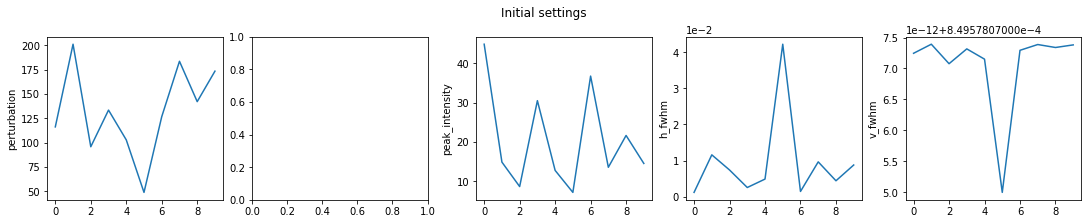

In [57]:
fig, axes = plt.subplots(1, 5, figsize=[15,3], constrained_layout=True)

axes[0].plot(absolute_movements)
axes[0].set_ylabel('perturbation')

#axes[1].plot(initial_centroids)
#axes[1].set_ylabel('v_centroid')

axes[2].plot(initial_peaks)
axes[2].set_ylabel('peak_intensity')

axes[3].plot(initial_h_fwhms)
axes[3].set_ylabel('h_fwhm')
axes[3].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[4].plot(initial_v_fwhms)
axes[4].set_ylabel('v_fwhm')
axes[4].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('Initial settings')
fig.savefig(f'{fig_save_path}/initial_metrics.png', bbox_inches='tight')

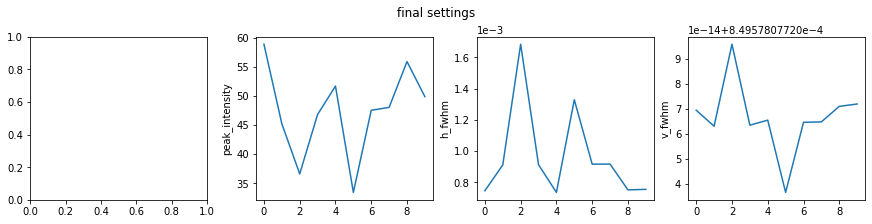

In [58]:
fig, axes = plt.subplots(1, 4, figsize=[12,3], constrained_layout=True)

#axes[0].plot(final_centroids)
#axes[0].set_ylabel('v_centroid')

axes[1].plot(final_peaks)
axes[1].set_ylabel('peak_intensity')

axes[2].plot(final_h_fwhms)
axes[2].set_ylabel('h_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))


axes[3].plot(final_v_fwhms)
axes[3].set_ylabel('v_fwhm')
axes[2].ticklabel_format(style='sci', scilimits=(-3, -5))

fig.suptitle('final settings')
fig.savefig(f'{fig_save_path}/final_metrics.png', bbox_inches='tight')

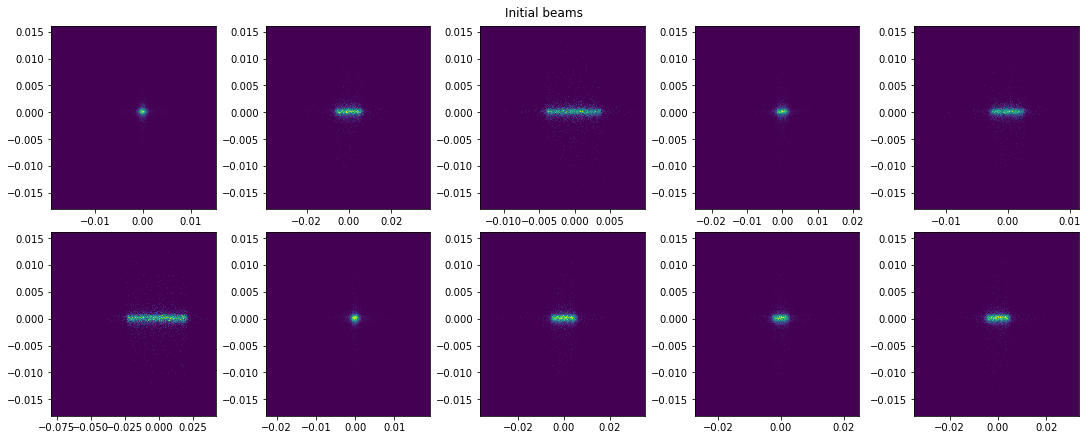

In [59]:
fig, axes = plt.subplots(2, 5, figsize=[15,6], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(initial_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D)
    
    
fig.suptitle('Initial beams')
fig.savefig(f'{fig_save_path}/initial_beams.png', bbox_inches='tight')

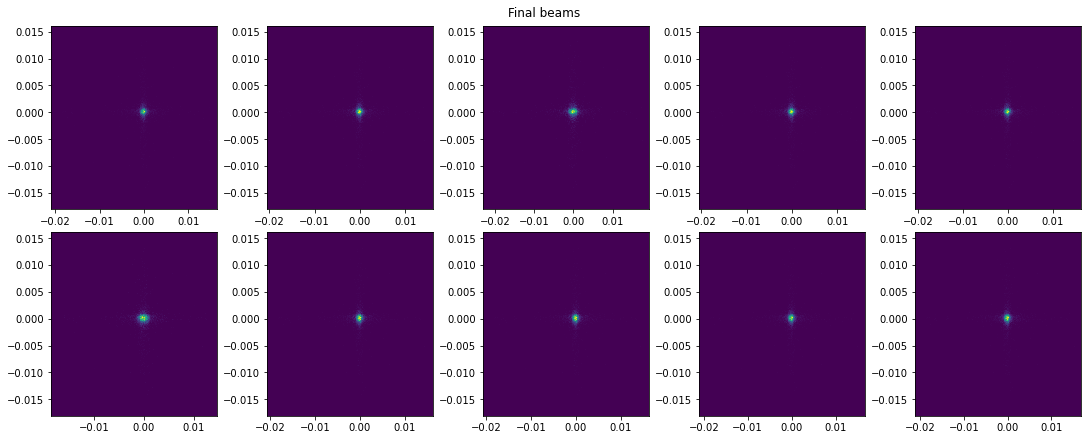

In [60]:
fig, axes = plt.subplots(2, 5, figsize=[15,6], constrained_layout=True)

axes_flat = axes.flatten()
for ix, h in enumerate(final_hists):
    axes_flat[ix].pcolormesh(h.hh, h.vv, h.data_2D)
    
    
fig.suptitle('Final beams')
fig.savefig(f'{fig_save_path}/final_beams.png', bbox_inches='tight')

In [25]:
clean_up()

In [26]:
shutil.rmtree(temp_work_dir)